In [54]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import save_model
import seaborn as sns


In [55]:
def load_images_from_folder(folder_path):
    images = []
    labels = []

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue  # Skip non-image files

            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipped (corrupt or unreadable): {img_path}")
                continue

            try:
                img = cv2.resize(img, (64, 64))
                images.append(img)
                labels.append(class_name.replace("_test", "").replace("_train", "").strip())
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return np.array(images), np.array(labels)


In [56]:
X_train, y_train = load_images_from_folder("C:/Users/ADMIN/Downloads/chatbot-main/Backend/Pest Detection/train")
X_test, y_test = load_images_from_folder("C:/Users/ADMIN/Downloads/chatbot-main/Backend/Pest Detection/test")


In [57]:
print(f"Loaded training samples: {len(X_train)}")
print(f"Loaded test samples: {len(X_test)}")

if len(X_train) == 0 or len(y_train) == 0:
    raise ValueError("Training data is empty. Check your dataset path and contents.")
if len(X_test) == 0 or len(y_test) == 0:
    raise ValueError("Test data is empty. Check your dataset path and contents.")


Loaded training samples: 3737
Loaded test samples: 450


In [58]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [59]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

# Filter out unseen labels in y_test
valid_test_indices = [i for i, label in enumerate(y_test) if label in le.classes_]
y_test_filtered = [y_test[i] for i in valid_test_indices]
X_test_filtered = X_test[valid_test_indices]

# Transform the filtered y_test
y_test_enc = le.transform(y_test_filtered)

# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train_enc, num_classes=len(le.classes_))
y_test_cat = to_categorical(y_test_enc, num_classes=len(le.classes_))

# Check shapes for consistency
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_test_filtered shape:", X_test_filtered.shape)
print("y_test_cat shape:", y_test_cat.shape)


X_train shape: (3737, 64, 64, 3)
y_train_cat shape: (3737, 7)
X_test_filtered shape: (350, 64, 64, 3)
y_test_cat shape: (350, 7)


In [60]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(le.classes_), activation='softmax')  # Output layer with the number of unique classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=10, validation_data=(X_test_filtered, y_test_cat))


c:\Users\ADMIN\Downloads\chatbot-main\.venv310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.3407 - loss: 1.7516 - val_accuracy: 0.6057 - val_loss: 1.1499
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.5413 - loss: 1.2153 - val_accuracy: 0.7514 - val_loss: 0.7863
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.7287 - loss: 0.7370 - val_accuracy: 0.8543 - val_loss: 0.5004
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.8526 - loss: 0.4138 - val_accuracy: 0.9200 - val_loss: 0.3742
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.9140 - loss: 0.2434 - val_accuracy: 0.9457 - val_loss: 0.4028
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9565 - loss: 0.1512 - val_accuracy: 0.9571 - val_loss: 0.3408
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.9702 - loss: 0.1091 - val_accuracy: 0.9543 - val_loss: 0.3064
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9775 - loss: 0

In [61]:
test_loss, test_accuracy = model.evaluate(X_test_filtered, y_test_cat)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9876 - loss: 0.0922
Test Accuracy: 96.29%


Filtered y_test_classes: 346
Filtered y_pred_classes: 346
Classification Report:
              precision    recall  f1-score   support

      sawfly       0.93      1.00      0.96       100
      beetle       1.00      1.00      1.00        50
       aphid       1.00      0.98      0.99        50
        mite       0.99      0.94      0.96       100
    armyworm       0.95      0.91      0.93        46

    accuracy                           0.97       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.97      0.97      0.97       346



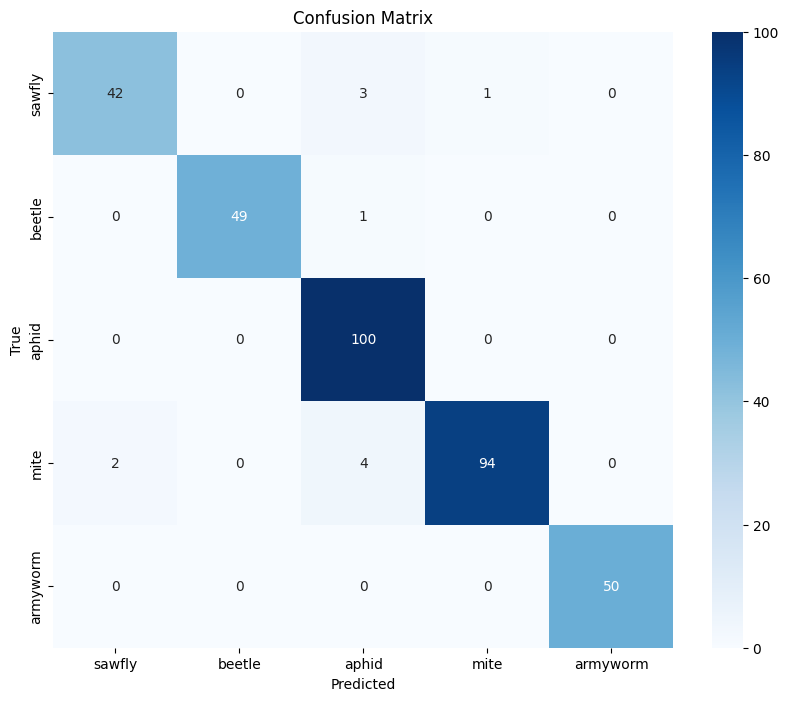

In [75]:
# Ensure we only filter out valid labels for both y_test_classes and y_pred_classes
valid_class_labels = set(class_mapping.values())  # Valid class labels as strings

# Find valid indices where both y_test_classes_str and y_pred_classes_str have valid labels
valid_indices = [
    i for i, (test_label, pred_label) in enumerate(zip(y_test_classes_str, y_pred_classes_str))
    if test_label in valid_class_labels and pred_label in valid_class_labels
]

# Filter y_test_classes_str and y_pred_classes_str using the valid indices
y_test_classes_filtered = [y_test_classes_str[i] for i in valid_indices]
y_pred_classes_filtered = [y_pred_classes_str[i] for i in valid_indices]

# Check the lengths of filtered lists
print(f"Filtered y_test_classes: {len(y_test_classes_filtered)}")
print(f"Filtered y_pred_classes: {len(y_pred_classes_filtered)}")

# If the lengths are non-zero, proceed with classification report
if len(y_test_classes_filtered) > 0 and len(y_pred_classes_filtered) > 0:
    print("Classification Report:")
    print(classification_report(y_test_classes_filtered, y_pred_classes_filtered, target_names=list(valid_class_labels)))

    # Confusion Matrix
    cm = confusion_matrix(y_test_classes_filtered, y_pred_classes_filtered, labels=list(valid_class_labels))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(valid_class_labels), yticklabels=list(valid_class_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
else:
    print("No valid classes left after filtering. Check if your test and prediction classes match the valid classes.")

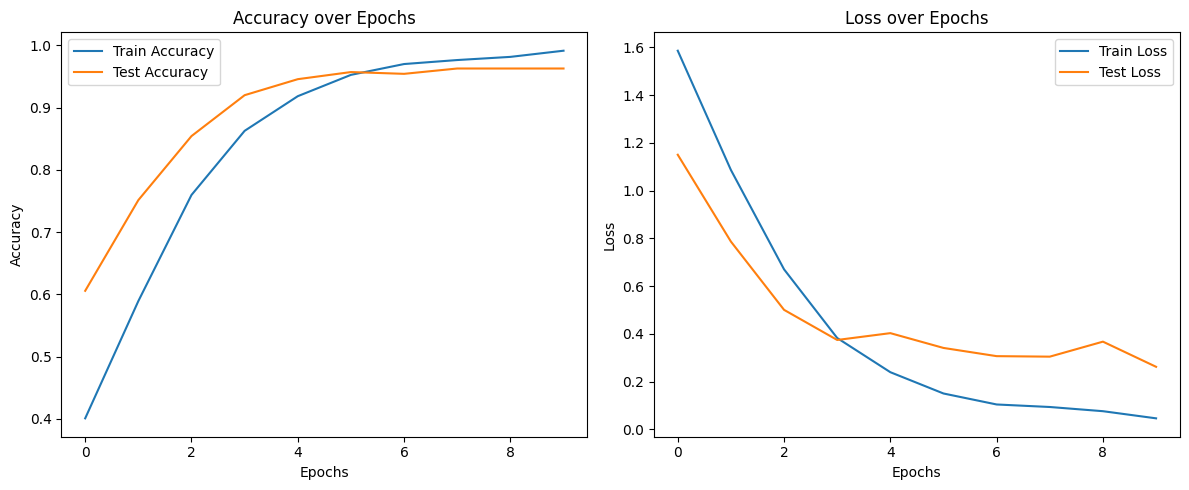

In [76]:
# Plotting the training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [77]:
# Save the trained model
model.save('pest_detection_model.h5')
print("Model saved as 'pest_detection_model.h5'")

Model saved as 'pest_detection_model.h5'
